# Topological Data Analysis (TDA) for Time Series

## Vadim Selyutin

Topological Data Analysis (TDA) is now an emerging area for analyzing complex data. TDA refers to a class of methods that garner information from topological structures in data that belong to a topological space. Output from TDA may then be used for effective statistical learning about the data. TDA combines algebraic topology and other tools from pure mathematics to allow a useful study of shape of the data. Computational topology, is an overlap between the mathematical underpinnings of topology with computer science, and consists of two parts, i.e., measuring the topology of a space and persistent homology.


Persistent homology refers to a class of methods for measuring topological features of shapes
and functions. It converts the data into simplicial complexes and describes the topological structure of a space at different spatial resolutions. Persistent homology elicits persistence of essential topologies in the data and outputs the birth and death of such topologies via a persistence diagram, which is a popular summary statistic in TDA.


Development of TDA for time series is a relatively new and fast growing area, with many interesting applications in several different domains. Periodic and semi periodic patterns are very common in nature. This project is an introduction to the field of TDA and a demonstration of its application on both generated and real world time series. I present a topological toolbox aiming in detecting and quantifying periodicity.

In [5]:
import time
import numpy as np
import pandas as pd
from scipy import sparse
from ripser import ripser
from persim import plot_diagrams
from persim import wasserstein, wasserstein_matching
from persim import bottleneck, bottleneck_matching
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
import seaborn as sns
from IPython.display import Audio
import scipy.io.wavfile
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
from IPython.display import display, Image

# 1. Point cloud to persistence diagram

### Basic review

First, let's describe the procedure to elicit topological features of data starting from a point cloud.

Denote the point cloud as $P = \{\textbf{v}_i: i=1,\ldots ,N\}$, where $\textbf{v}_i \in R^d$. When $d=2$, the points lie on the plane. 

Let $\textbf{D}_E = \{D_E(\textbf{v}_i, \textbf{v}_j)\}$ be the $N\times N$ matrix of Euclidean distances, for $i,j=1,\ldots ,N$.

For each $\textbf{v}_i \in P$, let $\textbf{B}_\lambda (\textbf{v}_i) = \{\textbf{x}: D_E(\textbf{x},\textbf{v}_i) \leq \lambda /2, \textbf{x}\in R^d\}$ denote a closed ball with radius $\lambda /2$; $0\leq\lambda\leq U$, where the upper-bound $U$ is usually pre-determined as the maximum of the distances in $\textbf{D}_E$.

A Vietoris-Rips simplex corresponding to a given $\lambda$ is defined as the set of points $P_V(\lambda)\subset P$ such that any points $\textbf{v}_{i_1}, \textbf{v}_{i_2}$ in $P_V(\lambda)$ satisfy $D_E(\textbf{v}_{i_1}, \textbf{v}_{i_2})\leq\lambda$, where $1\leq i_1,i_2\leq N$.

For a given $\lambda$ value, a simplicial complex $\tilde{k}(\lambda)$ denotes the set of Vietoris-Rips simplexes such that for any two Vietoris-Rips simplexes $P^{(1)}_V(\lambda), P^{(2)}_V(\lambda)\in \tilde{k}(\lambda)$:
- $P^{(1)}_V(\lambda)\cap P^{(2)}_V(\lambda)\in \tilde{k}(\lambda)$;
- if $P'\subset P^{(1)}_V$, then $P'\in\tilde{k}(\lambda)$.

A simplicial complex consisting of $(\tilde p + 1)$ points (from different Vietoris-Rips simplexes) is a $\tilde p$ - dimensional simplicial complex. In algebraic topology, $\tilde p$ is at most $N-1$ when the point cloud has $N$ points.

The topology of the point cloud is studied through the topology of the simplicial complexes, denoted by $\{\tilde{\alpha}_{\tilde{p},k}: k=1,\ldots ,k_{\tilde p}\}$, and $\tilde{\alpha}_{\tilde{p},k}$ is a homology group, consisting of a set of $\tilde p$-dimensional simplicial complexes which are homomorphic. As the parameter $\lambda$ gradually increases, the birth and death of homology groups $\{\tilde{\tau}_{\tilde{p},k} = (\lambda_{\tilde p, k, 1}, \lambda_{\tilde p, k, 2}):k=1,\ldots ,k_{\tilde p}\}$ are recorded in the persistence diagram $\tilde \Omega$.

For an increasing values of $\lambda$, if an elder topology $\tilde{\alpha}_{\tilde{p},k_1}$ and a younger one $\tilde{\alpha}_{\tilde{p},k_2}$ merge into a single $\tilde{\alpha}_{\tilde{p},k}$ at some $\lambda$, $\tilde{\alpha}_{\tilde{p},k_1}$ would become $\tilde{\alpha}_{\tilde{p},k}$ and $\tilde{\alpha}_{\tilde{p},k_2}$ would die. We plot $\lambda_{\tilde p, k, 1}$ on the $x$-axis and $\lambda_{\tilde p, k, 1}$ on the $y$-axis.

### Example

I illustrate construction of the persistence diagram for a point cloud with $N=100$ points sampled from the unit circle $x_1^2 + x_2^2 = 1$. The point cloud is shown in the plot below. We expect to see here a total of $k_0 = 100$ values of $\tilde{\alpha}_{0,k}$ and $k_1 = 1$ value of $\tilde{\alpha}_{1,k}$. When $\lambda$ reaches its maximum value of 2, the algorithm stops and outputs the persistence diagram which finally shows the birth-death times for all connected components (the blue dots) and the tunnel (the orange dot).

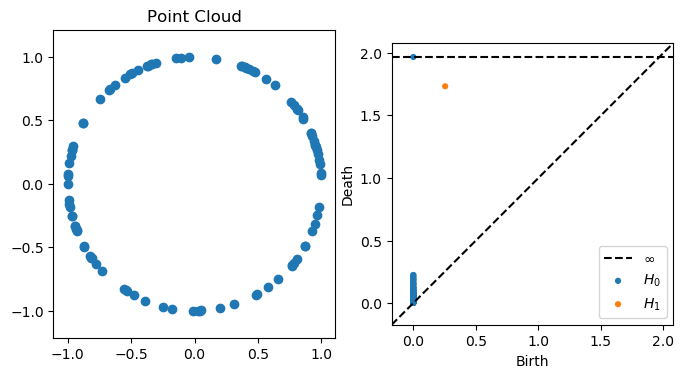

In [3]:
N = 100
t = np.random.uniform(0, 2 * np.pi, N)
X = np.zeros((N, 2))
X[:, 0] = np.cos(t)
X[:, 1] = np.sin(t)

# persistence diagram
dgms = ripser(X)['dgms']

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1])
plt.axis('equal')
plt.title("Point Cloud")
plt.subplot(122)
plot_diagrams(dgms)
plt.show()

# 2. Distances between persistence diagrams

Two distance metrics are commonly used to quantify the dissimilarity between two persistence diagrams $\tilde \Omega_1$ and $\tilde \Omega_2$, the Wasserstein distance and the bottleneck distance.

The $q$-Wasserstein distance between two persistence diagrams is defined by
$$\textbf{W}_{q,\tilde p}\left(\tilde \Omega_1, \tilde \Omega_2\right) = \left[ \inf_{\eta: \tilde \Omega_1\rightarrow \tilde \Omega_2}\sum_{\tilde{\tau}_{\tilde{p},k}\in\tilde \Omega_1} \left|\tilde{\tau}_{\tilde{p},k} - \eta(\tilde{\tau}_{\tilde{p},k})\right|^q_\infty \right]^{1/q}, q=1,2,\ldots ,$$
where $\tilde p$ is is referred to as its dimension and $q$ is its degree. When $q=\infty$, $\textbf{W}_{q,\tilde p}\left(\tilde \Omega_1, \tilde \Omega_2\right)$ is the bottleneck distance of dimension $\tilde p$ defined by
$$\textbf{W}_{\infty,\tilde p}\left(\tilde \Omega_1, \tilde \Omega_2\right) = \inf_{\eta: \tilde \Omega_1\rightarrow \tilde \Omega_2} \sup_{\tilde{\tau}_{\tilde{p},k}\in\tilde \Omega_1}  \left|\tilde{\tau}_{\tilde{p},k} - \eta(\tilde{\tau}_{\tilde{p},k})\right|_\infty. $$
The bottleneck distance is obtained by minimizing the largest distance of any two corresponding points of diagrams, over all bijections between $\tilde \Omega_1$ and $\tilde \Omega_2$ and is less sensitive to details in the diagrams.

### Example

Let's do a simple example of matching the persistence diagram for points sampled from a circle to the diagram from a noisy version of that circle. The Wasserstein distance is larger than the bottleneck distance since the former measures more detailed difference between the diagrams.

Bottleneck Dist: 0.2331
Wasserstein Dist: 0.2888


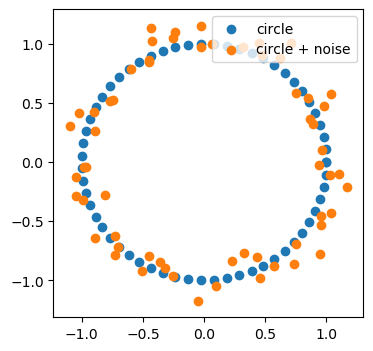

In [35]:
# circle
N = 60
t = np.linspace(0, 2 * np.pi, N)
X1 = np.zeros((N, 2))
X1[:, 0] = np.cos(t)
X1[:, 1] = np.sin(t)
I1 = ripser(X1)['dgms'][1]

# circle + noise
X2 = X1 + 0.1 * np.random.randn(N, 2)
I2 = ripser(X2)['dgms'][1]

# matchings
bdist, _ = bottleneck(I1, I2, matching=True)
wdist, _ = wasserstein(I1, I2, matching=True)

print("Bottleneck Dist: %.4g"%bdist)
print("Wasserstein Dist: %.4g"%wdist)

plt.figure(figsize=(4, 4))
plt.scatter(X1[:, 0], X1[:, 1], label='circle')
plt.scatter(X2[:, 0], X2[:, 1], label='circle + noise')
plt.legend(loc='upper right')
plt.show()

# 3. Takens’s delay embedding for time series

Let $\{x_t, t=1,2,\ldots ,T\}$ denote an observed time series. We use Takens’s embedding to convert the time series into a point cloud with points $\textbf{v}_i = \left(x_i, x_{i+\tau},\ldots ,x_{i+(d-1)\tau}\right)$, where d specifies the dimension of the points and $\tau$ denotes a delay parameter. Both $d$ and $\tau$ are unknown and must be determined in practice.

### Example

In this example I generate point clouds from 2 periodic cosine signals of length 480 with periods 12 and 48 and one more from the second signal plus some noise, and then construct their persistent diagrams.

In [9]:
def sliding_window(x, tau, d):
    x = np.array(x)
    v = []
    for i in range(0, len(x) - (d - 1)*tau):
        inds = np.arange(i, i + (d - 1)*tau + 1, tau)
        v.append(x[inds])
    return np.array(v)

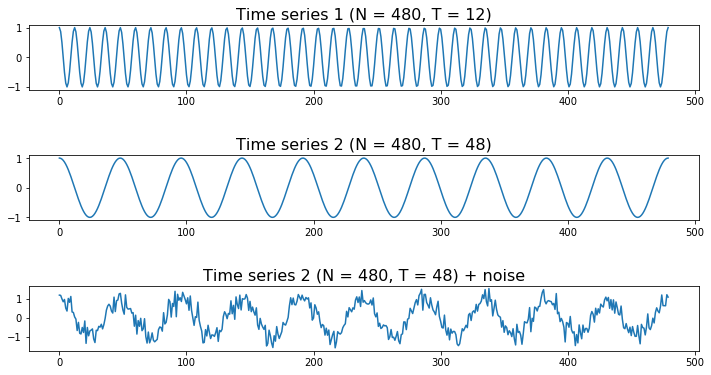

In [21]:
N = 480

# first 
T1 = 12
t1 = np.linspace(0, 2 * np.pi * (N // T1), N)
x1 = np.cos(t1)

# second
T2 = 48
t2 = np.linspace(0, 2 * np.pi * (N // T2), N)
x2 = np.cos(t2)

# second + noise
T3 = 48
noise = 0.3 * np.random.randn(N)
t3 = np.linspace(0, 2 * np.pi * (N // T3), N)
x3 = np.cos(t3) + noise

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12,6))
fig.subplots_adjust(hspace=1)

ax1.plot(x1)
ax1.set_title('Time series 1 (N = 480, T = 12)', fontsize=16)

ax2.plot(x2)
ax2.set_title('Time series 2 (N = 480, T = 48)', fontsize=16)

ax3.plot(x3)
ax3.set_title('Time series 2 (N = 480, T = 48) + noise', fontsize=16)
plt.show()

The plots below present a two dimensional view of the point clouds constructed with $d = 5$ and $\tau = 3$, via the first two principal components. Seeing a circle indicates that the time series is periodic. As we can see from the third plot, additional noise destroys the circle structure.

PCA 1: lambda1 = 1.50631, lambda2 = 1.00008
PCA 2: lambda1 = 1.82352, lambda2 = 0.660588
PCA 3: lambda1 = 1.85558, lambda2 = 0.735288


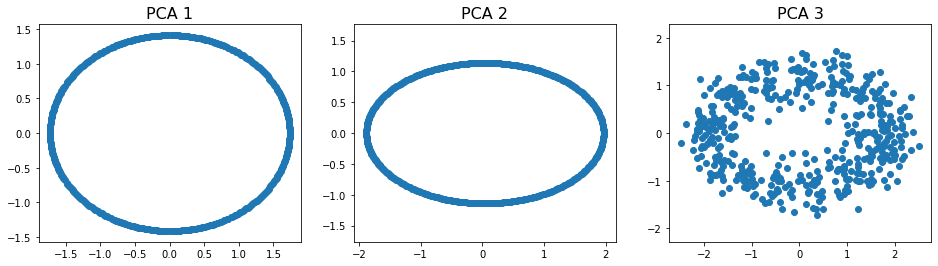

In [23]:
d = 5
tau = 3

v1 = sliding_window(x1, tau, d)
v2 = sliding_window(x2, tau, d)
v3 = sliding_window(x3, tau, d)

pca = PCA(n_components = 2)

y1 = pca.fit_transform(v1)
eigs = pca.explained_variance_
print("PCA 1: lambda1 = %g, lambda2 = %g"%(eigs[0], eigs[1]))

y2 = pca.fit_transform(v2)
eigs = pca.explained_variance_
print("PCA 2: lambda1 = %g, lambda2 = %g"%(eigs[0], eigs[1]))

y3 = pca.fit_transform(v3)
eigs = pca.explained_variance_
print("PCA 3: lambda1 = %g, lambda2 = %g"%(eigs[0], eigs[1]))

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))
fig.subplots_adjust(hspace=1)

ax1.scatter(y1[:, 0], y1[:, 1])
ax1.set_title('PCA 1', fontsize=16)
ax1.axis('equal')

ax2.scatter(y2[:, 0], y2[:, 1])
ax2.set_title('PCA 2', fontsize=16)
ax2.axis('equal')

ax3.scatter(y3[:, 0], y3[:, 1])
ax3.set_title('PCA 3', fontsize=16)
ax3.axis('equal')
plt.show()

The blue dots represent the birth-death of 0-th homology groups and their persistence shows the dispersion of the points in the point cloud. The orange dots represent the birth-death of 1-th homology groups, indicating circles in the point cloud.

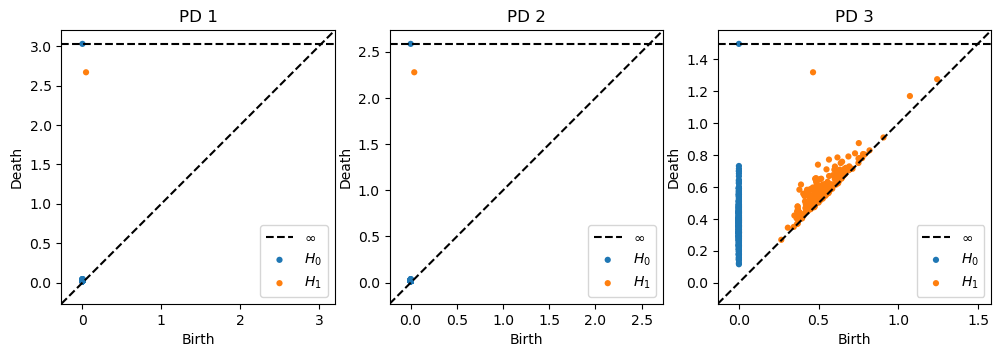

In [8]:
dgms1 = ripser(v1)['dgms']
dgms2 = ripser(v2)['dgms']
dgms3 = ripser(v3)['dgms']

plt.figure(figsize=(12, 4))
plt.subplot(131)
plt.title('PD 1')
plot_diagrams(dgms1)

plt.subplot(132)
plt.title('PD 2')
plot_diagrams(dgms2)

plt.subplot(133)
plt.title('PD 3')
plot_diagrams(dgms3)
plt.show()

# 4. Times series generation

I implement the function that generates periodic or nonperiodic time series with the desired number of points. To make periodic time series more similar to the real life samples I add some noise to its values. I obtain nonperiodic time series by adding such a significant noise value to some random periodic time series that they ceases to be periodic.

In [11]:
def generate_time_series(N, periodic=True):
    T = np.random.randint(10,50)
    t = np.linspace(0, 2 * np.pi * (N // T), N)
    coef = np.random.uniform()
    x = coef * np.cos(t) + (1 - coef) * np.sin(t) + 0.2 * np.random.randn(N)
    if not periodic:
        noise = np.random.randn(N)
        x = x + noise
    scaler = MinMaxScaler((-1, 1))
    x = scaler.fit_transform(x.reshape(-1,1)).flatten()
    return x

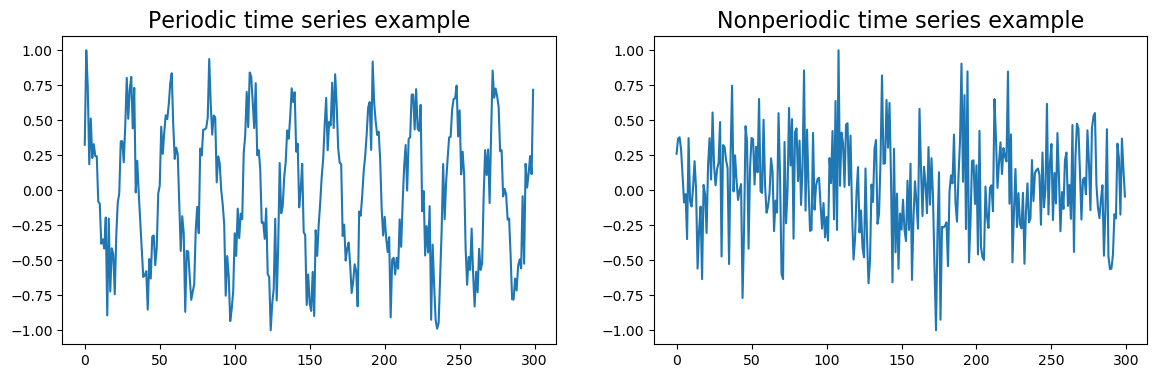

In [12]:
plt.figure(figsize=(14, 4))
plt.subplot(121)
plt.title('Periodic time series example', fontsize=16)
plt.plot(generate_time_series(300))
plt.subplot(122)
plt.title('Nonperiodic time series example', fontsize=16)
plt.plot(generate_time_series(300, periodic=False))
plt.show()

I generate 500 periodic and 500 nonperiodic time series of 400 points each and convert them to point clouds with $d = 2$ and $\tau = 3$.

In [21]:
d = 2
tau = 3
N = 400
ts_num = 500

# generate TS -> point cloud
periodic_pc = [sliding_window(generate_time_series(N),tau,d) for i in range(ts_num)]
nonperiodic_pc = [sliding_window(generate_time_series(N, periodic=False),tau,d) for i in range(ts_num)]
point_clouds = np.concatenate([periodic_pc, nonperiodic_pc])

y = np.hstack([np.zeros(ts_num), np.ones(ts_num)])

Let's have a look at the examples of obtained point clouds from each class. One might notice that the circle structure still presents in the point cloud of the periodic time series while the point cloud of nonperiodic time series looks like a mess.

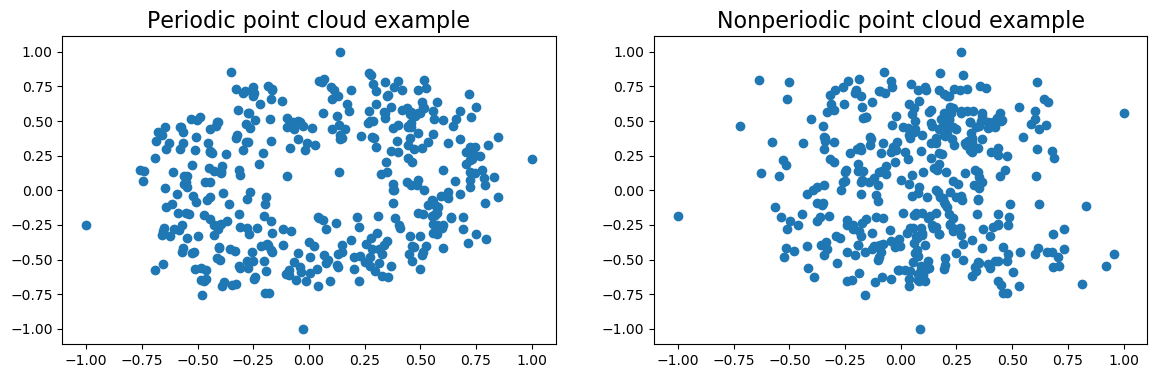

In [22]:
plt.figure(figsize=(14, 4))
plt.subplot(121)
plt.title('Periodic point cloud example', fontsize=16)
plt.scatter(point_clouds[0][:,0], point_clouds[0][:,1])
plt.subplot(122)
plt.title('Nonperiodic point cloud example', fontsize=16)
plt.scatter(point_clouds[ts_num + 10][:,0], point_clouds[0][:,1])
plt.show()

# 5. Feature construction using TDA

With the help of the function below for the given point cloud I acquire the persistence diagram
$\tilde \Omega = \left\{\tilde{\tau}_{\tilde{p},k}|k=1,\ldots ,k_{\tilde p}; \tilde p = 0,1\right\}$, where $\tilde{\tau}_{\tilde{p},k} = \left(\lambda_{\tilde p, k, 1}, \lambda_{\tilde p, k, 2}\right)$, and construct the following set of features:
- The number of points on each dimension $\tilde p$, i.e., $\left(k_0,k_1,\ldots ,k_{\tilde p}\right)$;
- The maximum lifetime of each $\tilde p$, i.e, $\max_k\left(\lambda_{\tilde p, k, 2}- \lambda_{\tilde p, k, 1} \right)$;
- The number of relevant points for each $\tilde p$, namely $\#\left\{\tilde{\tau}_{\tilde{p},k}|\lambda_{\tilde p, k, 2}- \lambda_{\tilde p, k, 1}\geq 0.5 \max_k \left(\lambda_{\tilde p, k, 2}- \lambda_{\tilde p, k, 1} \right)   \right\}$, where # denotes the cardinality of the set;
- The average lifetime of all homology groups on each $\tilde p$, $\sum_{k=1}^{k_{\tilde p}}\left(\lambda_{\tilde p, k, 2}- \lambda_{\tilde p, k, 1} \right) / k_{\tilde p}$;
- The sum of the lifetimes of all homology groups on each $\tilde p$, $\sum_{k=1}^{k_{\tilde p}}\left(\lambda_{\tilde p, k, 2}- \lambda_{\tilde p, k, 1} \right)$.

In [23]:
def extract_features(pnt_cloud):
    features_values = []
    zero_hom_groups, first_hom_groups = ripser(pnt_cloud)['dgms']
    zero_hom_groups = zero_hom_groups[:-1]
    zero_delta = np.subtract(zero_hom_groups[:,1], zero_hom_groups[:,0])
    first_delta = np.subtract(first_hom_groups[:,1], first_hom_groups[:,0])
    
    # points_num
    features_values.append(len(zero_hom_groups))
    features_values.append(len(first_hom_groups))
    
    # max_lifetime
    features_values.append(np.max(zero_delta))
    features_values.append(np.max(first_delta))
    
    # avg_lifetime
    features_values.append(np.average(zero_delta))
    features_values.append(np.average(first_delta))
    
    # lifetimes_sum
    features_values.append(np.sum(zero_delta))
    features_values.append(np.sum(first_delta))
    
    # relevant points num
    features_values.append(len(np.where(zero_delta >= 0.5 * np.max(zero_delta))[0]))
    features_values.append(len(np.where(first_delta >= 0.5 * np.max(first_delta))[0]))
    
    return features_values

Let's apply this function to all point clouds of the generated time series.

In [24]:
# X = []
# for pnt_cloud in tqdm(point_clouds):
#     X.append(extract_features(pnt_cloud))   

# X = pd.DataFrame(X, columns=['points_num_0', 'points_num_1', 'max_lifetime_0', 'max_lifetime_1',
#                          'avg_lifetime_0', 'avg_lifetime_1', 'lifetimes_sum_0', 'lifetimes_sum_1',
#                          'rel_pnts_num_0', 'rel_pnts_num_1'])
# X.to_csv('topological_features.csv')


X = pd.read_csv('./topological_features.csv')

I normalize the obtained dataset and divide it into train and test parts.

In [25]:
X_norm = normalize(X)
X_train, X_test, y_train, y_test = train_test_split(X_norm, y, test_size=0.3, shuffle=True)

# 6. Classifiers

In this section I test the performance of three classifiers (Logistic Regression, SVM and XGBoost) on our topological features and check whether it is possible to predict periodicity of time series with their help. Models parameters are tuned via the GridSearchCV.

### Logistic Regression

In [26]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

param_grid = {
    'penalty':['l1', 'l2'],
    'C':np.logspace(-3,3,7)}

log_gr_s = GridSearchCV(logreg, param_grid, cv=10, scoring='f1')
log_gr_s.fit(X_train, y_train)

print("Best parameters (CV f1 score=%0.3f):" % log_gr_s.best_score_)
print(log_gr_s.best_params_)

log_gr_s.best_estimator_.fit(X_train, y_train)
print('Precision', precision_score(y_test, log_gr_s.best_estimator_.predict(X_test)))
print('Recall', recall_score(y_test, log_gr_s.best_estimator_.predict(X_test)))
print('F1-score', f1_score(y_test, log_gr_s.best_estimator_.predict(X_test)))

Best parameters (CV f1 score=0.910):
{'C': 1000.0, 'penalty': 'l1'}
Precision 0.9319727891156463
Recall 0.8896103896103896
F1-score 0.9102990033222591


### SVM

In [27]:
from sklearn.svm import SVC
svc = SVC()

param_grid = {
    'C':[1,10,100,1000],
    'gamma':[1,0.1,0.001,0.0001],
    'kernel':['linear','rbf']}

svc_gr_s = GridSearchCV(svc, param_grid, cv=10, scoring='f1')
svc_gr_s.fit(X_train, y_train)
print("Best parameters (CV f1 score=%0.3f):" % svc_gr_s.best_score_)
print(svc_gr_s.best_params_)

svc_gr_s.best_estimator_.fit(X_train, y_train)
print('Precision', precision_score(y_test, svc_gr_s.best_estimator_.predict(X_test)))
print('Recall', recall_score(y_test, svc_gr_s.best_estimator_.predict(X_test)))
print('F1-score', f1_score(y_test, svc_gr_s.best_estimator_.predict(X_test)))

Best parameters (CV f1 score=0.775):
{'C': 1000, 'gamma': 0.1, 'kernel': 'rbf'}
Precision 0.7898089171974523
Recall 0.8051948051948052
F1-score 0.797427652733119


### XGBoost

In [28]:
from xgboost import XGBClassifier
xgb = XGBClassifier()

param_grid = {'n_estimators':[50, 70, 100], 
              'max_depth': range(2,11,3),
              'colsample_bytree': [0.8],
              'subsample': [0.8],
              'learning_rate': [0.05],
             },

xgb_gr_s = GridSearchCV(xgb, param_grid, cv=10, scoring='f1')
xgb_gr_s.fit(X_train, y_train)
print("Best parameters (CV f1 score=%0.3f):" % xgb_gr_s.best_score_)
print(xgb_gr_s.best_params_)

xgb_gr_s.best_estimator_.fit(X_train, y_train)
print('Precision', precision_score(y_test, xgb_gr_s.best_estimator_.predict(X_test)))
print('Recall', recall_score(y_test, xgb_gr_s.best_estimator_.predict(X_test)))
print('F1-score', f1_score(y_test, xgb_gr_s.best_estimator_.predict(X_test)))

Best parameters (CV f1 score=0.951):
{'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 100, 'subsample': 0.8}
Precision 0.937888198757764
Recall 0.9805194805194806
F1-score 0.9587301587301588


# 7. Closer look at TDA features

### SelectKBest

Let's compate features importances via statistical tests. It turned our that the numbers of relevant points for both dimensions are the most important features to predict time series periodicity. At the same time the number of points on the 0-th dimension is useless.

In [34]:
bestfeatures = SelectKBest(score_func=chi2, k=10)
fit = bestfeatures.fit(X,y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
featureScores = pd.concat([dfcolumns,dfscores], axis=1)
featureScores.columns = ['Feature', 'Score']
print(featureScores.nlargest(10, 'Score'))

           Feature       Score
8   rel_pnts_num_0  917.757364
9   rel_pnts_num_1  817.640505
1     points_num_1   87.098256
3   max_lifetime_1   12.847038
2   max_lifetime_0    9.997188
6  lifetimes_sum_0    1.430367
5   avg_lifetime_1    0.019425
4   avg_lifetime_0    0.003612
7  lifetimes_sum_1    0.000083
0     points_num_0    0.000000


### Correlation matrix

It's not surprising that the average lifetime of all homology groups of one dimension correlates with the sum of the lifetimes of all homology groups on the same dimension. But still features correlation matrix tells us that such an average correlates with such a sum even for different dimensions.

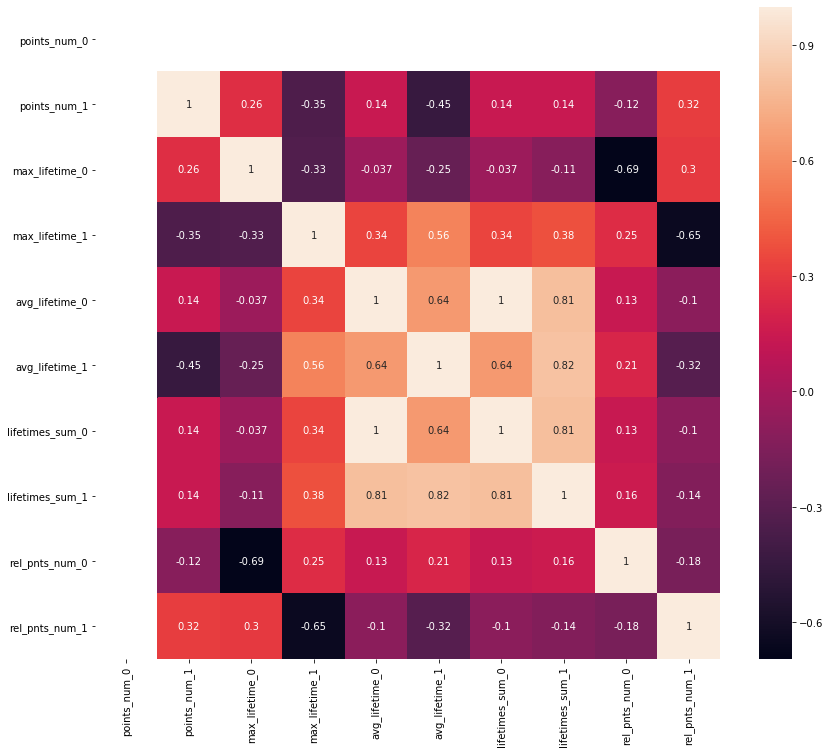

In [43]:
plt.figure(figsize=(14,12))
corrMatrix = X.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

# 8. Audio applications

Now let's try this approach on the real music! For this purpose I've chosen the famous meme music 'Mr. Dudec', which is with no doubt periodic.

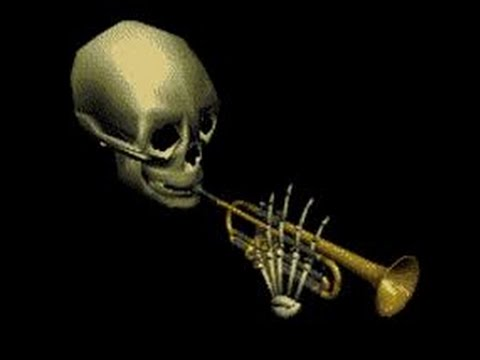

In [4]:
display(Image(filename='dudec_img.jpg'))

In [507]:
# from os import path
# from pydub import AudioSegment

# src = "./mr_dudec.mp3"
# dst = "./mr_dudec.wav"

# # convert wav to mp3                                                            
# sound = AudioSegment.from_mp3(src)
# sound.export(dst, format="wav")

I sample some middle part of the song.

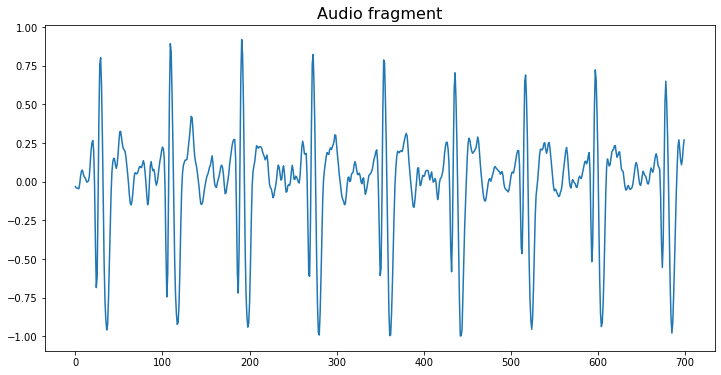

In [512]:
Fs, X = scipy.io.wavfile.read("mr_dudec.wav")
X = X[:,0]
X = X/(2.0**15) #Loaded in as 16 bit shorts, convert to float
X = X[700:1400]

plt.figure(figsize=(12,6))
plt.plot(X)
plt.title('Audio fragment', fontsize=16)
plt.show()

After that I apply moving average transformation to make the signal more smooth.

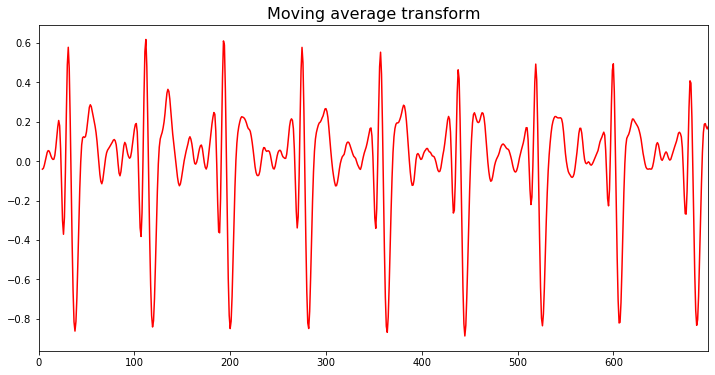

In [513]:
series = pd.DataFrame(X, columns=['ts'])
rolling = series.rolling(window=5)
rolling_mean = rolling.mean()

rolling_mean.plot(color='red', figsize=(12,6), legend=False)
plt.title('Moving average transform', fontsize=16)
plt.show()

I obtain point cloud with $d = 2, \tau = 5$. As you can see there is some round structure on the graph.

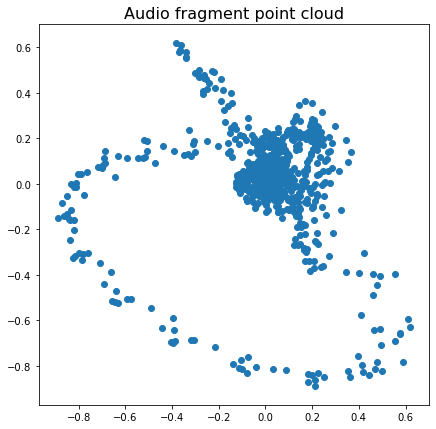

In [514]:
ts = rolling_mean.dropna().values.flatten()
music_pc = sliding_window(ts, tau=5, d=2)

plt.figure(figsize=(7, 7))
plt.title('Audio fragment point cloud', fontsize=16)
plt.scatter(music_pc[:,0], music_pc[:,1])
plt.show()

Let's now check what will be the decision of the trained models we've evaluate before.

In [535]:
def model_decision(answer):
    if not answer:
        return 'The signal is periodic.'
    else:
        return 'The signal is non-periodic.'


music_features = pd.DataFrame([extract_features(music_pc)])
music_features = normalize(music_features)

print('XGBoost:\t\t', model_decision(xgb_gr_s.best_estimator_.predict(music_features)[0]))
print('Logistic Regression:\t', model_decision(log_gr_s.best_estimator_.predict(music_features)[0]))
print('SVM:\t\t\t', model_decision(svc_gr_s.best_estimator_.predict(music_features)[0]))

XGBoost:		 The signal is periodic.
Logistic Regression:	 The signal is periodic.
SVM:			 The signal is periodic.


Here it is! The method works!

# 9. Conclusion

This project gives an overview of basic TDA techniques which consists of a set of powerful tools for construction of the time series topological features and using it for periodicity detection. Research extensions in several directions are possible. More thorough testing of this approach requires the generation of more diverse time series with varying degrees of noise.

# 10. References

1. Original article: https://arxiv.org/abs/1909.10604
2. Another interesting TDA approach: https://arxiv.org/pdf/1905.12118.pdf
3. TDA labs: https://github.com/ctralie/TDALabs
4. Intro to TDA: https://github.com/trneedham/IntroductionToTopologicalDataAnalysis
5. Non-mathy article on Persistent Homology: https://towardsdatascience.com/persistent-homology-with-examples-1974d4b9c3d0